## Treinamento de Modelos de Machine Learning para Previsão de Retorno de Ações

Este notebook demonstra o processo de geração de features, criação de targets e treinamento de modelos Random Forest Regressor
para previsão de retornos futuros de ações, com base em um script completo de otimização de portfólio.

In [2]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from PortfolioOptimizer import PortfolioOptimizer
from scipy.stats import spearmanr

### Carregamento dos dados e preparação da classe de otimização

In [3]:
# Carregar os dados históricos salvos localmente
df_total = pd.read_csv('../datas/dados_base.csv')

# Ajustar os tipos de colunas
df_total['Date'] = pd.to_datetime(df_total['Date'])
df_total['Close'] = df_total['Close'].astype(float)
df_total['High'] = df_total['High'].astype(float)
df_total['Low'] = df_total['Low'].astype(float)
df_total['Open'] = df_total['Open'].astype(float)
df_total['Volume'] = df_total['Volume'].astype(int)
df_total['ticker'] = df_total['ticker'].astype(str)

# Inicializar o otimizador
USER_TICKERS = ['AAPL', 'GOOG', 'AMZN', 'NFLX', 'MSFT', 'IBM']
BENCHMARK_TICKER = '^GSPC'
optimizer = PortfolioOptimizer(df_total_data=df_total, tickers_list=USER_TICKERS, benchmark_ticker=BENCHMARK_TICKER)

Carregando e processando dados do DataFrame fornecido...
Dados carregados com sucesso. Período analisado: 2007-01-03 até 2025-05-09
Total de dias de negociação no período: 4618
Tickers incluídos no portfólio: AAPL, GOOG, AMZN, NFLX, MSFT, IBM
Benchmark utilizado: ^GSPC


## Geração de features e targets para ML

In [4]:
# Preparar features e targets com retorno futuro de 10 dias para menor ruido, alocação dinâmica
features_df, targets_dict = optimizer.prepare_ml_features(target_window=10)


--- Preparando Features para Modelos de Machine Learning ---
Features e targets preparados. Shape das features: (4518, 50). Número de targets: 6.


### Treinamento e Avaliação dos Modelos

Experimentos realizados com diferentes estratégias de modelagem

1. Random Forest com hiperparâmetros padrão (baseline)
2. Random Forest com melhoria dos hiperparâmetros
3. Random Forest com tuning via GridSearchCV e validação temporal

1. Random Forest com hiperparâmetros padrão (baseline)

In [4]:
models_dict = {}
performance_dict = {}

for ticker in USER_TICKERS:
    print(f"Treinando modelo para: {ticker}")

    X = features_df.copy()
    y = targets_dict[ticker]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    oob = model.oob_score_

    print(f"MSE: {mse:.4f} | R²: {r2:.4f} | OOB: {oob:.4f}")

    models_dict[ticker] = model
    performance_dict[ticker] = {"mse": mse, "r2": r2, "oob_score": oob}

Treinando modelo para: AAPL
MSE: 0.0034 | R²: -0.1470 | OOB: 0.7146
Treinando modelo para: GOOG
MSE: 0.0035 | R²: -0.0656 | OOB: 0.7110
Treinando modelo para: AMZN
MSE: 0.0052 | R²: -0.0017 | OOB: 0.6919
Treinando modelo para: NFLX
MSE: 0.0106 | R²: -0.1101 | OOB: 0.7307
Treinando modelo para: MSFT
MSE: 0.0025 | R²: -0.0327 | OOB: 0.6953
Treinando modelo para: IBM
MSE: 0.0024 | R²: -0.0229 | OOB: 0.7017


 Sobre o R2 negativo:

Embora o R² seja uma métrica comum para avaliar modelos de regressão, ele não é a melhor referência em contextos de otimização de portfólio. Isso porque o objetivo aqui não é prever com precisão o valor exato dos retornos futuros, mas sim capturar relações relativas entre os ativos, ou seja, identificar quais tendem a performar melhor ou pior. Um modelo com R² baixo pode ainda assim gerar alocações eficientes se for capaz de ordenar corretamente os ativos por potencial de retorno, levando a portfólios com bom desempenho em métricas como Sharpe, drawdown ou retorno ajustado ao risco.


Teste de Modelo de LGBM para APPLE

(sem ganhos para o Random Forest Regressor)

In [5]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# X e y já devem estar prontos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_r2 = r2_score(y_test, rf.predict(X_test))
rf_mse = mean_squared_error(y_test, rf.predict(X_test))

# LightGBM
lgb = LGBMRegressor(n_estimators=100, random_state=42)
lgb.fit(X_train, y_train)
lgb_r2 = r2_score(y_test, lgb.predict(X_test))
lgb_mse = mean_squared_error(y_test, lgb.predict(X_test))

print("Random Forest - R²:", rf_r2, " | MSE:", rf_mse)
print("LightGBM      - R²:", lgb_r2, " | MSE:", lgb_mse)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 3614, number of used features: 50
[LightGBM] [Info] Start training from score 0.003044
Random Forest - R²: -0.022905961943677555  | MSE: 0.002382594326092302
LightGBM      - R²: -0.2120263121042163  | MSE: 0.0028231011664130736


2. Melhora dos Parametros do Random Forest

In [6]:
models_dict = {}
performance_dict = {}

for ticker in USER_TICKERS:
    print(f"Treinando modelo para: {ticker}")

    X = features_df.copy()
    y = targets_dict[ticker]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    min_samples_leaf=10,
    max_features='sqrt',
    bootstrap=True,
    max_samples=0.8,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    oob = model.oob_score_

    print(f"MSE: {mse:.4f} | R²: {r2:.4f} | OOB: {oob:.4f}")

    models_dict[ticker] = model
    performance_dict[ticker] = {"mse": mse, "r2": r2, "oob_score": oob}

Treinando modelo para: AAPL
MSE: 0.0031 | R²: -0.0371 | OOB: 0.1628
Treinando modelo para: GOOG
MSE: 0.0034 | R²: -0.0304 | OOB: 0.1267
Treinando modelo para: AMZN
MSE: 0.0052 | R²: -0.0085 | OOB: 0.1410
Treinando modelo para: NFLX
MSE: 0.0094 | R²: 0.0165 | OOB: 0.2109
Treinando modelo para: MSFT
MSE: 0.0025 | R²: -0.0088 | OOB: 0.1413
Treinando modelo para: IBM
MSE: 0.0024 | R²: -0.0148 | OOB: 0.1570


3. Random Forest com tuning via GridSearchCV e validação temporal

Queremos encontrar a melhor combinação de hiperparâmetros para o RandomForestRegressor, avaliando seu desempenho com uma técnica que respeita a ordem do tempo.

Com o GridSearchCV testamos todas as combinações possíveis dos hiperparâmetros definidos.

Com o TimeSeriesSplit usamos uma forma de validação cruzada (CV) sem embaralhar os dados.

Treina no nosso caso 18 modelos, e ficamos com o melhor R2.

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import joblib
import os

USER_TICKERS = ['AAPL', 'GOOG', 'AMZN', 'NFLX', 'MSFT', 'IBM']

param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 'log2']
}

tscv = TimeSeriesSplit(n_splits=5)

rf = RandomForestRegressor(
    n_estimators=300,
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

melhores_parametros_por_ticker = {}

for ticker in USER_TICKERS:
    print(f"\nTuning para: {ticker}")
    X = features_df.copy()
    y = targets_dict[ticker]
    X, y = X.loc[y.index], y.loc[X.index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    grid = GridSearchCV(rf, param_grid, cv=tscv, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_

    # Avaliar o modelo no teste
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    oob = best_model.oob_score_ if hasattr(best_model, 'oob_score_') else None

    melhores_parametros_por_ticker[ticker] = {
        'melhores_parametros': grid.best_params_,
        'r2_validacao_cruzada': grid.best_score_,
        'best_model': best_model,
        'metrics': {
            'mse': mse,
            'r2': r2,
            'oob_score': oob
        }
    }



for ticker, info in melhores_parametros_por_ticker.items():
    caminho = f"../api/model/ml_model_{ticker}.joblib"
    joblib.dump(info['best_model'], caminho)
    print(f"Modelo salvo: {caminho}")



Tuning para: AAPL

Tuning para: GOOG

Tuning para: AMZN

Tuning para: NFLX

Tuning para: MSFT

Tuning para: IBM
Modelo salvo: ../api/model/ml_model_AAPL.joblib
Modelo salvo: ../api/model/ml_model_GOOG.joblib
Modelo salvo: ../api/model/ml_model_AMZN.joblib
Modelo salvo: ../api/model/ml_model_NFLX.joblib
Modelo salvo: ../api/model/ml_model_MSFT.joblib
Modelo salvo: ../api/model/ml_model_IBM.joblib


Como foi o melhor modelo em termos de r2 neste primeiro momento, foi o selecionado para a otimizaçao do portfólio e utilizaçao na API

### Otimização do portfólio com os modelos treinados

In [ ]:
# --- Otimização do portfólio com base nas previsões dos modelos ---
ml_optimization_results = optimizer.optimize_ml_portfolio(models_dict, features_df)




--- Otimizando Portfólio com Base em Previsões de Machine Learning ---
  Retornos previstos para o próximo período: {'AAPL': np.float64(0.021674730431978435), 'GOOG': np.float64(0.011720686744511667), 'AMZN': np.float64(0.019535066932621758), 'NFLX': np.float64(0.013957469429114926), 'MSFT': np.float64(0.005068679001091514), 'IBM': np.float64(0.012037487043870301)}
Otimização com ML concluída!
  Retorno Esperado Anual do Portfólio (histórico com pesos ML): 0.2771
  Volatilidade Anual do Portfólio (histórico com pesos ML): 0.2565
  Índice de Sharpe Anualizado (histórico com pesos ML): 1.0024
  Pesos Ótimos (baseados em ML):
    AAPL: 0.2581
    GOOG: 0.1395
    AMZN: 0.2326
    NFLX: 0.1662
    MSFT: 0.0603
    IBM: 0.1433


Backtest com os pesos otimizados


--- Realizando Backtesting do Portfólio ---
  Período do Backtest: 2007-05-14 até 2025-05-09 (4528 dias)
  Retorno Total do Portfólio: 7272.9866%
  Retorno Anualizado do Portfólio: 27.0402%
  Volatilidade Anualizada do Portfólio: 25.7052%
  Índice de Sharpe do Portfólio: 0.9741
  Máximo Drawdown do Portfólio: -51.2655%


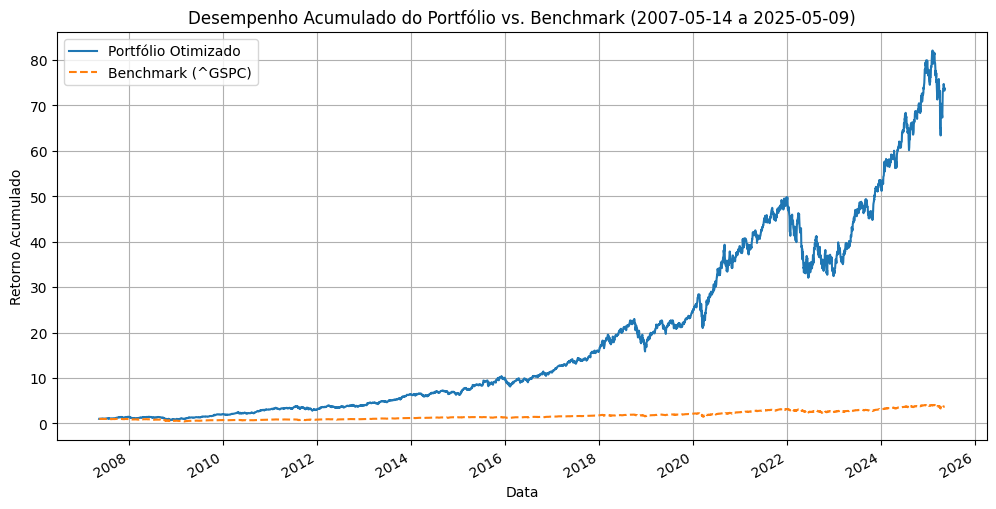

In [16]:
# --- Backtest da estratégia com os pesos calculados ---
backtest_results = optimizer.backtest_portfolio(
    weights_input=ml_optimization_results['weights'],
    start_date_str=features_df.index[0].strftime('%Y-%m-%d')  # início das features
)



### Conclusão e Interpretação:

Período do Backtest: de 14/05/2007 a 09/05/2025, totalizando 4528 dias úteis.

Retorno Total do Portfólio: 7272,99% – o capital multiplicou mais de 73 vezes no período.

Retorno Anualizado: 27,04% ao ano – crescimento médio composto anual.

Volatilidade Anualizada: 25,71% – indica alta oscilação nos retornos.

Índice de Sharpe: 0,97 – retorno razoável em relação ao risco; valores acima de 1 são considerados bons.

Máximo Drawdown: -51,27% – pior queda registrada do topo ao fundo, ou seja, o portfólio chegou a perder mais da metade do valor em determinado momento.

### Limitações e Próximos Passos

O modelo de machine learning foi utilizado para prever retornos e gerar uma alocação ótima de ativos, com foco na maximização do retorno ajustado ao risco.

O backtest realizado aplicou os pesos gerados com base nas previsões feitas no fim da base de dados (última linha de features), e simulou seu desempenho retroativamente desde 2007.

Essa abordagem é útil como validação do potencial dos sinais gerados pelos modelos, mas possui uma limitação importante: os pesos utilizados não estariam disponíveis em 2007, o que caracteriza um viés de lookahead.

Portanto, os resultados obtidos não devem ser interpretados como o que seria possível alcançar na prática, mas sim como uma simulação exploratória da capacidade dos modelos de orientar decisões de alocação.

Implementar um backtest com rebalanceamento periódico, onde os pesos são recalculados ao longo do tempo, com base apenas nas informações disponíveis até cada momento.